In [1]:
using POMDPs, POMDPTools, QuickPOMDPs, MCTS, DiscreteValueIteration, POMDPSimulators, POMDPModels, POMDPPolicies
using Distributions, Combinatorics, StaticArrays, D3Trees, Random
using FileIO, JLD2, TickTock

In [2]:
Transition_matrix = [
    0.63 0.37 0.0  0.0;
    0.0  0.71 0.29 0.0;
    0.0  0.0  0.77 0.23;
    0.0  0.0  0.0  1.0
]

obs_mean = [0.196, 0.496, 0.670]
obs_std = [0.02, 0.02, 0.02]

global Number_level = 4;
global Action_num = 4;

   Resolving package versions...
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Manifest.toml`


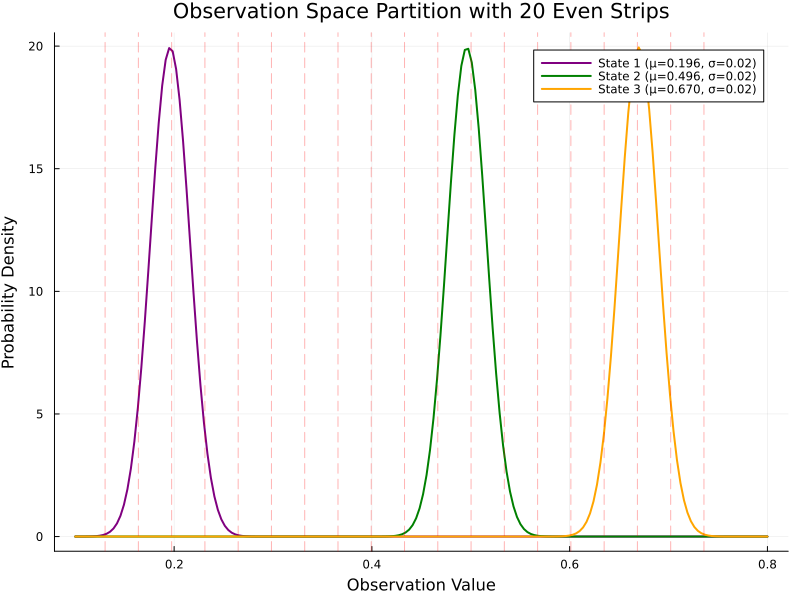


Strip Information:
Number of strips: 20
Strip width: 0.03
Strip 1: (0.13, 0.13]
Strip 2: (0.13, 0.164]
Strip 3: (0.164, 0.197]
Strip 4: (0.197, 0.231]
Strip 5: (0.231, 0.265]
Strip 6: (0.265, 0.298]
Strip 7: (0.298, 0.332]
Strip 8: (0.332, 0.366]
Strip 9: (0.366, 0.399]
Strip 10: (0.399, 0.433]
Strip 11: (0.433, 0.467]
Strip 12: (0.467, 0.5]
Strip 13: (0.5, 0.534]
Strip 14: (0.534, 0.568]
Strip 15: (0.568, 0.601]
Strip 16: (0.601, 0.635]
Strip 17: (0.635, 0.669]
Strip 18: (0.669, 0.702]
Strip 19: (0.702, 0.736]
Strip 20: (0.736, 0.736]

Observation Matrix:
State 1:
  O[1,1] = 0.0005
  O[1,2] = 0.0534
  O[1,3] = 0.4756
  O[1,4] = 0.431
  O[1,5] = 0.0392
  O[1,6] = 0.0003
State 2:
  O[2,10] = 0.0008
  O[2,11] = 0.0703
  O[2,12] = 0.5139
  O[2,13] = 0.3861
  O[2,14] = 0.0288
  O[2,15] = 0.0002
State 3:
  O[3,15] = 0.0003
  O[3,16] = 0.0392
  O[3,17] = 0.431
  O[3,18] = 0.4756
  O[3,19] = 0.0534
  O[3,20] = 0.0005
State 4 (Failure):
  O[4,21] = 1.0

Row sums (should all be ≈ 1.0):
State 1

In [3]:
import Pkg;
Pkg.add("Plots")
Pkg.add("Distributions")
using Plots
using Distributions
gr() # Use GR backend explicitly

# Parameters
obs_mean = [0.196, 0.496, 0.670]
obs_std = [0.02, 0.02, 0.02]

# Transition matrix
Transition_matrix = [
    0.63 0.37 0.0 0.0;
    0.0 0.71 0.29 0.0;
    0.0 0.0 0.77 0.23;
    0.0 0.0 0.0 1.0
]

# Function to get range that covers most probability mass for all states
function get_observation_range(obs_mean, obs_std; coverage=0.999)
    min_val = Inf
    max_val = -Inf
    for (μ, σ) in zip(obs_mean, obs_std)
        dist = Normal(μ, σ)
        lower = quantile(dist, (1 - coverage)/2)
        upper = quantile(dist, 1 - (1 - coverage)/2)
        min_val = min(min_val, lower)
        max_val = max(max_val, upper)
    end
    return (min_val, max_val)
end

# Get range and generate boundaries
min_val, max_val = get_observation_range(obs_mean, obs_std)
n_strips = 20
boundaries = range(min_val, max_val, n_strips-1)
strip_width = (max_val - min_val) / n_strips

# Create the plot
p = plot(size=(800, 600),
    xlabel="Observation Value",
    ylabel="Probability Density",
    title="Observation Space Partition with 20 Even Strips",
    legend=:topright)

# Plot the normal distributions
x = range(0.1, 0.8, length=200)  # Modified range to match new means
colors = [:purple, :green, :orange]
labels = ["State 1 (μ=0.196, σ=0.02)", 
          "State 2 (μ=0.496, σ=0.02)", 
          "State 3 (μ=0.670, σ=0.02)"]

for i in 1:3
    dist = Normal(obs_mean[i], obs_std[i])
    plot!(x, pdf.(dist, x),
        color=colors[i],
        label=labels[i],
        linewidth=2)
end

# Add vertical lines for strip boundaries
for b in boundaries
    vline!([b],
        color=:red,
        linestyle=:dash,
        label="",
        alpha=0.3)
end

# Display the plot
display(p)

savefig(p, "observation_space.png")

# Print strip information
println("\nStrip Information:")
println("Number of strips: $n_strips")
println("Strip width: $(round(strip_width, digits=3))")
for i in 1:n_strips
    if i == 1
        left = min_val
        right = boundaries[1]
    elseif i == n_strips
        left = boundaries[end]
        right = max_val
    else
        left = boundaries[i-1]
        right = boundaries[i]
    end
    println("Strip $i: ($(round(left, digits=3)), $(round(right, digits=3))]")
end

using POMDPs
using POMDPTools

# Define observations as a union of all possible strips and failure
const FAILURE_OBS = 21 # Constant for failure observation
const NUM_STRIPS = 20 # Number of regular strips

function create_observation_matrix(obs_mean, obs_std, boundaries, Number_level)
    O = zeros(Number_level, FAILURE_OBS) # States × Observations
    
    # Fill probabilities for non-failure states
    for s in 1:(Number_level-1)
        dist = Normal(obs_mean[s], obs_std[s])
        
        # Calculate probabilities for each strip
        for i in 1:NUM_STRIPS
            if i == 1
                O[s,i] = cdf(dist, boundaries[1])
            elseif i == NUM_STRIPS
                O[s,i] = 1 - cdf(dist, boundaries[end])
            else
                O[s,i] = cdf(dist, boundaries[i]) - cdf(dist, boundaries[i-1])
            end
        end
    end
    
    # Fill probabilities for failure state
    O[Number_level, FAILURE_OBS] = 1.0
    
    return O
end

# Create and display the matrix
Number_level = 4  # Number of states including failure
Observation_matrix = create_observation_matrix(obs_mean, obs_std, boundaries, Number_level)

# Print the observation matrix
println("\nObservation Matrix:")
for s in 1:Number_level
    if s == Number_level
        println("State $s (Failure):")
    else
        println("State $s:")
    end
    
    # Print non-zero probabilities
    for o in 1:FAILURE_OBS
        prob = Observation_matrix[s,o]
        if prob > 1e-4  # Only print probabilities > 0.0001
            println("  O[$s,$o] = $(round(prob, digits=4))")
        end
    end
end

# Verify row sums
println("\nRow sums (should all be ≈ 1.0):")
for s in 1:Number_level
    println("State $s: $(sum(Observation_matrix[s,:]))")
end

In [4]:
global Number_level = 4;
global Action_num = 4;

gamma=0.95

T=zeros(Number_level,Number_level,3);
T[:,:,1].=Transition_matrix;
T[:,:,2].=Transition_matrix;
for j in 1:Number_level
    T[j,:,3].=Transition_matrix[1,:];
    end
T[Number_level,:,1].=0.0
T[Number_level,Number_level,1]=1.0
T[Number_level,:,2].=Transition_matrix[1,:]

4-element view(::Array{Float64, 3}, 4, :, 2) with eltype Float64:
 0.63
 0.37
 0.0
 0.0

In [5]:
T

4×4×3 Array{Float64, 3}:
[:, :, 1] =
 0.63  0.37  0.0   0.0
 0.0   0.71  0.29  0.0
 0.0   0.0   0.77  0.23
 0.0   0.0   0.0   1.0

[:, :, 2] =
 0.63  0.37  0.0   0.0
 0.0   0.71  0.29  0.0
 0.0   0.0   0.77  0.23
 0.63  0.37  0.0   0.0

[:, :, 3] =
 0.63  0.37  0.0  0.0
 0.63  0.37  0.0  0.0
 0.63  0.37  0.0  0.0
 0.63  0.37  0.0  0.0

In [6]:
Observation_matrix

4×21 Matrix{Float64}:
 0.0005        0.0533907     …  0.0       0.0        0.0     0.0
 4.92296e-75   3.03717e-62      0.0       0.0        0.0     0.0
 9.54618e-161  1.29591e-141     0.475618  0.0533907  0.0005  0.0
 0.0           0.0              0.0       0.0        0.0     1.0

In [7]:
NumberUnits=20
limit=12
failure_penalty = -1200.0;
maintenance_penalty = -100.0;
setup_cost = -300.0;
normal_operation = 0.0;
system_penalty=-2000

-2000

In [8]:
import Pkg; Pkg.add("QMDP")

   Resolving package versions...
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Manifest.toml`


In [9]:
States=Array((1:Number_level))
Observations=Array((1:FAILURE_OBS))

using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPSimulators, QMDP

In [10]:
Observations

21-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [11]:
SparseCat(Observations, Observation_matrix[1,:])

                SparseCat distribution           
      ┌                                        ┐ 
    1 ┤ 0.0004999999999999912                    
    2 ┤■■ 0.053390657896811154                   
    3 ┤■■■■■■■■■■■■■■■■■■■■ 0.4756179805200451   
    4 ┤■■■■■■■■■■■■■■■■■■ 0.4309740865839715     
    5 ┤■■ 0.03922490569653769                    
    6 ┤ 0.00029221724365624535                   
    7 ┤ 1.5205386072469906e-7                    
    8 ┤ 5.117573032009659e-12                    
    9 ┤ 0.0                                      
   10 ┤ 0.0                                      
   11 ┤ 0.0                                      
   12 ┤ 0.0                                      
   13 ┤ 0.0                                      
   14 ┤ 0.0                                      
   15 ┤ 0.0                                      
   16 ┤ 0.0                                      
   17 ┤ 0.0                                      
   18 ┤ 0.0                                      


In [12]:
Initialstates = zeros(Number_level)
Initialstates[1]=1.0
Initialstates

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

In [13]:
Initialstate = SparseCat(States, Initialstates)

               SparseCat distribution           
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1.0   
   2 ┤ 0.0                                      
   3 ┤ 0.0                                      
   4 ┤ 0.0                                      
     └                                        ┘ 

In [14]:
Initialobs = SparseCat(Observations, Observation_matrix[1,:])

                SparseCat distribution           
      ┌                                        ┐ 
    1 ┤ 0.0004999999999999912                    
    2 ┤■■ 0.053390657896811154                   
    3 ┤■■■■■■■■■■■■■■■■■■■■ 0.4756179805200451   
    4 ┤■■■■■■■■■■■■■■■■■■ 0.4309740865839715     
    5 ┤■■ 0.03922490569653769                    
    6 ┤ 0.00029221724365624535                   
    7 ┤ 1.5205386072469906e-7                    
    8 ┤ 5.117573032009659e-12                    
    9 ┤ 0.0                                      
   10 ┤ 0.0                                      
   11 ┤ 0.0                                      
   12 ┤ 0.0                                      
   13 ┤ 0.0                                      
   14 ┤ 0.0                                      
   15 ┤ 0.0                                      
   16 ┤ 0.0                                      
   17 ┤ 0.0                                      
   18 ┤ 0.0                                      


In [15]:
multiunit = QuickPOMDP(
    states=States,
    actions=Array((1:Action_num)),
    observations = Observations,
    #initialstate = repeat(1:1,NumberUnits),
    initialstate = Initialstate,
    #initialobs = repeat(1:1,NumberUnits),
    initialobs = Initialobs,
    discount = gamma,

    transition = function(s,a)
        if a == 1 # NO REPAIR, NO SYSTEM FAILURE
            #crd = Categorical(T[s,:,1]);
            #s = rand(crd);
            return SparseCat(States, T[s,:,1])
        end
        if a == 2 # UNIT NOT REPAIRED UNLESS FAILURE BUT REPAIR IN SYSTEM
            if s == Number_level
                s = 1
                #crd = Categorical(T[s,:,2]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,2])
            else
                #crd = Categorical(T[s,:,2]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,2])
            end
        end
        if a == 3 # UNIT REPAIRED AND MAINTENANCE IN SYSTEM, NO SYSTEM FAILURE
            if s==Number_level
                s=1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,3])
            else
                s = 1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,3])
            end
        end
        if a == 4 # UNIT REPAIRED AND MAINTENANCE IN SYSTEM,SYSTEM FAILED
            if s==Number_level
                s=1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,3])
            else
                s = 1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return SparseCat(States, T[s,:,3])
            end
        end
    end,

    observation = function(a,s)
        return SparseCat(Observations, Observation_matrix[s,:])
    end,
        
    reward = function (s, a)
        if a == 1 # NO REPAIR, NO SYSTEM FAILURE
            if s == Number_level
                return system_penalty/(limit)
            else
                return normal_operation
            end
            #crd = Categorical(T[s,:,1]);
            #s = rand(crd);
        end
        if a == 2 # UNIT NOT REPAIRED UNLESS FAILURE BUT REPAIR IN SYSTEM, NO SYSTEM FAILURE PENALTY
            if s == Number_level
                #s = 1
                #crd = Categorical(T[s,:,2]);
                #s = rand(crd);
                return failure_penalty +  setup_cost/NumberUnits + normal_operation
            else
                # Here it doesn't matter whether systems fails or not, since C_b does not apply to functional units
                return normal_operation +  setup_cost/NumberUnits
            end
        end
        if a == 3 # UNIT REPAIRED AND MAINTENANCE IN SYSTEM, NO SYSTEM FAILURE PENALTY
            if s==Number_level
                #s=1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return failure_penalty +  setup_cost/NumberUnits + normal_operation
            else
                # Here it doesn't matter whether systems fails or not, since C_b does not apply to functional units
                return maintenance_penalty +  setup_cost/NumberUnits+ normal_operation 
            end
        end
        if a == 4 # UNIT REPAIRED AND MAINTENANCE IN SYSTEM,SYSTEM FAILED
            if s==Number_level
                #s=1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return failure_penalty +  setup_cost/NumberUnits + normal_operation + system_penalty/(limit)
            else
                #s = 1
                #crd = Categorical(T[s,:,3]);
                #s = rand(crd);
                return maintenance_penalty +  setup_cost/NumberUnits + normal_operation
            end
        end
    end,
    

)

QuickPOMDP{Base.UUID("07208b03-49a8-49ab-9e95-efead0d9c0cb"), Int64, Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, obsindex::Dict{Int64, Int64}, states::Vector{Int64}, observations::Vector{Int64}, discount::Float64, initialobs::SparseCat{Vector{Int64}, Vector{Float64}}, actions::Vector{Int64}, observation::var"#3#6", actionindex::Dict{Int64, Int64}, initialstate::SparseCat{Vector{Int64}, Vector{Float64}}, transition::var"#2#5", reward::var"#4#7"}}((stateindex = Dict(4 => 4, 2 => 2, 3 => 3, 1 => 1), isterminal = false, obsindex = Dict(5 => 5, 16 => 16, 7 => 7, 20 => 20, 12 => 12, 8 => 8, 17 => 17, 1 => 1, 19 => 19, 4 => 4…), states = [1, 2, 3, 4], observations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12, 13, 14, 15, 16, 17, 18, 19, 20, 21], discount = 0.95, initialobs = SparseCat{Vector{Int64}, Vector{Float64}}([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [0.0004999999999999912, 0.053390657896811154, 0.4756179805200451, 0.43097408

In [16]:
initialstate(multiunit)

               SparseCat distribution           
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1.0   
   2 ┤ 0.0                                      
   3 ┤ 0.0                                      
   4 ┤ 0.0                                      
     └                                        ┘ 

In [17]:
import Pkg; Pkg.add("NativeSARSOP")
using POMDPs

using NativeSARSOP
using POMDPModels



   Resolving package versions...
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hhu98\.julia\environments\v1.11\Manifest.toml`


In [18]:
ordered_states(multiunit)

4-element Vector{Int64}:
 1
 2
 3
 4

In [19]:
length(states(multiunit))

4

In [20]:
#import Pkg; Pkg.add("IncrementalPruning")

In [21]:
# using IncrementalPruning
# solver = PruneSolver() # set the solver

# policy = solve(solver, multiunit)

In [22]:
#value(policy,[0.1,0.8,0.1,0.0])

In [23]:
solver = SARSOPSolver()
policy = solve(solver, multiunit)
# Calling observation

AlphaVectorPolicy{QuickPOMDP{Base.UUID("07208b03-49a8-49ab-9e95-efead0d9c0cb"), Int64, Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, obsindex::Dict{Int64, Int64}, states::Vector{Int64}, observations::Vector{Int64}, discount::Float64, initialobs::SparseCat{Vector{Int64}, Vector{Float64}}, actions::Vector{Int64}, observation::var"#3#6", actionindex::Dict{Int64, Int64}, initialstate::SparseCat{Vector{Int64}, Vector{Float64}}, transition::var"#2#5", reward::var"#4#7"}}, Int64}(QuickPOMDP{Base.UUID("07208b03-49a8-49ab-9e95-efead0d9c0cb"), Int64, Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, obsindex::Dict{Int64, Int64}, states::Vector{Int64}, observations::Vector{Int64}, discount::Float64, initialobs::SparseCat{Vector{Int64}, Vector{Float64}}, actions::Vector{Int64}, observation::var"#3#6", actionindex::Dict{Int64, Int64}, initialstate::SparseCat{Vector{Int64}, Vector{Float64}}, transition::var"#2#5", reward::var"#4#7"}}((stateinde

In [24]:
value(policy,[0.0,0.0,0.0,1.0])

-1544.0750063769535

In [25]:
value(policy,[0.1,0.1,0.8,0.0])

-444.07500637695364

In [26]:
b=[[0.0, 0.2, 0.8, 0.0] for j in 1:NumberUnits]
belief=b[1]
value(policy,belief)

-444.07500637695364

In [27]:
#transition function: transition(pomdp, state, action)
#return the transition distribution form the current state-action pair
transition(multiunit, 3,1)

               SparseCat distribution           
     ┌                                        ┐ 
   1 ┤ 0.0                                      
   2 ┤ 0.0                                      
   3 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.77   
   4 ┤■■■■■■■■■■ 0.23                           
     └                                        ┘ 

In [28]:
function generative(s,a,rng=23) # calculate TRUE COMPONENT-LEVEL reward r_i(s_i,a_i) and get evolving states
    if a==1 # No maintenance in the system, no system failure
        if s>5
            println("ERROR HERE")
        end
        crd=Categorical(T[s,:,1])
        s=rand(crd)
        r=normal_operation
        obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
        obs = rand(obs_distribution)
        return (sp=s,r=r,o=obs)
    end

    if a==2 # Maintenance occurs in the system, no system failure, corrective maintenance for the unit
        if s==Number_level
            crd=Categorical(T[1,:,2])
            s=rand(crd)
            r=failure_penalty  + normal_operation
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        else
            crd = Categorical(T[s,:,2])
            s = rand(crd)
            r = normal_operation
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        end
    end

    if a==3 # Maintenance occurs in the system, no system failure, preventive maintenance for the unit
        if s==Number_level
            crd=Categorical(T[1,:,3])
            s=rand(crd)
            r=failure_penalty  + normal_operation
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        else
            crd = Categorical(T[s,:,3])
            s = rand(crd)
            r = maintenance_penalty+normal_operation
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        end
    end

    if a==4 # maintenance in system, system failure occurs, preventive replacement for the unit
        if s==Number_level
            crd = Categorical(T[1,:,3])
            s = rand(crd)
            r=failure_penalty+ normal_operation
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        else
            r = maintenance_penalty+normal_operation
            crd = Categorical(T[1,:,3])
            s = rand(crd)
            obs_distribution = SparseCat(Observations, Observation_matrix[s,:])
            obs = rand(obs_distribution)
            return (sp=s,r=r,o=obs)
        end
    end
end

        
        
    

generative (generic function with 2 methods)

#### Belief updater

$$b'(s_j)=P(s_j\vert o,a,b)=\dfrac{P(o\vert s_j,a)\sum_{s_i\in \mathcal{S}}P(s_j\vert s_i,a)b(s_i)}{\sum_{s_j\in \mathcal{S}}P(o\vert s_j,a)\sum_{s_i\in \mathcal{S}}P(s_j\vert s_i,a)b(s_i)}$$

In [29]:
function update_belief(b,a,o,pomdp) 
    # NOTE: 
    # in input, b is belief from last epoch (before a)
    # a is the last action we took
    # o is the new observation after a
    updated_belief = zeros(length(b))
    if o==FAILURE_OBS
        updated_belief[length(states(pomdp))]=1.0
        return updated_belief
    end
    #if ((a==2)&&(o==4)) ||(a==3) ||(a==4)
    #if (a==2) ||(a==3) ||(a==4)
    if (a==3) ||(a==4)
    # We assume perfect maintenance and it is know to decision maker(belief updater)
        for sp in 1: length(states(pomdp))
            p_observation = POMDPs.observation(pomdp,a,sp) 
            p_obs = pdf(p_observation,o)
            # Transition probability distribution is T[1,:,1]
            p_trans = pdf(transition(pomdp,1,1),sp) 
            updated_belief[sp] = p_obs * p_trans
        end
        updated_belief ./= sum(updated_belief)
        return updated_belief
    end
    
    for sp in 1:length(states(pomdp)) 
        p_observation = POMDPs.observation(pomdp,a,sp) 
        p_obs = pdf(p_observation,o)
        p_trans = 0.0
        for s in 1:length(states(pomdp))
            #trans = transition(pomdp, s,a)
            #p_trans += pdf(transition(pomdp, s,a),sp) * pdf(b, s)
            # p_trans += T[s,sp,a] * pdf(b, s)
            p_trans += pdf(transition(pomdp,s,a),sp) * b[s]
        end
        updated_belief[sp] = p_obs * p_trans
    end
        # Normalize the updated belief state to ensure it sums up to 1
        updated_belief ./= sum(updated_belief)
    return updated_belief
end


update_belief (generic function with 1 method)

In [30]:
s=1
o=rand(SparseCat(Observations, Observation_matrix[s,:]))

2

In [31]:
# s=1
# sp=2
# a=1
# pdf(transition(multiunit, s,a),sp)

In [32]:
# updated_belief_state = update_belief(SparseCat(States, [0.1,0.9,0.0,0.0]), 2, 4, multiunit)

In [33]:
# updated_belief_state = update_belief([0.0,0.1,0.9,0.0], 2, 2, multiunit)

In [34]:
# #updated_belief_state = update_belief(SparseCat(States, [0.0,0.1,0.9,0.0]), 2, 2, multiunit)
# updated_belief_state = update_belief([0.0,0.1,0.9,0.0], 2, 3, multiunit)
# # result of distinguishing a=2 taken under different states

In [35]:
# updated_belief_state = update_belief([0.1,0.9,0.0,0.0], 1, 1, multiunit)

### System-level decision making

In [36]:
function decision(policy, o, b)
# initialize system-level action vector
    Q=Qfnc(policy,b) # Q is an N*A matrix for each unit-action pair
    a_final = repeat(1:1,NumberUnits)
    failed_components = 0
    for i in 1:NumberUnits # numerate over units
        if o[i]==FAILURE_OBS # failure state is self-announcing
            failed_components+=1
        end
    end
    if failed_components >= limit # System fails
        for i in 1:NumberUnits
            if o[i]==FAILURE_OBS
                a_final[i]=4
            else
                a_final[i]=argmax(a->Q[i,a],[2,3]) # If the unit does not fail, the case is the same as a=2,3
            end
        end
        return a_final
    end

    # Based on belief, compare the expected total rewards of setting up maintenance or not
    D0=0.0
    a0=repeat(1:1,NumberUnits)
    for i in 1:NumberUnits
        D0+=Q[i,1]
    end

    D1=0.0
    a1=repeat(1:1,NumberUnits)
    for i in 1:NumberUnits
        a1[i]=argmax(a->Q[i,a],[2,3])
        if o[i]==FAILURE_OBS
            a1[i]=3
        end
        D1+=Q[i,a1[i]]
    end

    if !(3 in a1)
        return a0
    end

    if D0 > D1
        return a0
    else
        return a1
    end
end


    
    
    


decision (generic function with 1 method)

# $Q$-function
After obtaining $V^*(b)$ from policy, we calculate optimal $Q$-function by
$$Q^*(b,a)=R(b,a)+\gamma  \sum_{o'\in \mathcal{O}} \eta(o'|b,a)V^*(b')$$
where expected immediate reward of taking action $a$ in belief state $b$ is $$R(b,a)=\sum_{s\in \mathcal{S}}R(s,a) b(s),$$
and prior probability of observing $o'$ after taking action $a$ is $$\eta(o'|b,a)=\sum_{s'\in\mathcal{S}} P(o'|s',a)\sum_{s\in\mathcal{S}}T(s'|s,a)b(s)$$

In [37]:
function Qfnc(policy,b)
    epsilon = 1e-4
    Q=zeros((NumberUnits,4)) 
    # NOTE: Q is defined for each unit (according to their beliefs), not state
    for i in 1:NumberUnits
        belief=b[i]
        # if i == 1
        #     println("The current belief is ",belief)
        # end
        for a in 1:4
            # if i==1
            # println("Take action ",a)
            # end
            Q_value=0
            for s in 1:Number_level
                Q_value+=belief[s] * POMDPs.reward(multiunit,s,a)
            end
            for o in 1:FAILURE_OBS
                # if i==1
                # println("prior probability of observing ",o," after taking action ",a)
                # end
            # the o here is the observation we expect to obtain at next time step, 
            # i.e., after taking the action we are deciding
            # so we don't need input current o
                o_prior = 0 
                for sp in 1:Number_level
                    p_sp=0
                    for s in 1:Number_level
                        p_sp+=pdf(transition(multiunit,s,a),sp) * belief[s]
                        #p_sp+=T[s,sp,a] * belief[s]
                    end
                    p_sp=p_sp * Observation_matrix[sp,o]
                    o_prior+=p_sp
                end
                #println(o_prior)
                bp=update_belief(belief,a,o,multiunit)
                # if i == 1
                #     println(o_prior)
                #     println("next time step belief vector after observing ",o)
                #     println(bp)
                # end
                if o_prior > epsilon
                    Q_value += gamma * o_prior * value(policy,bp)
                end
            end
            Q[i,a]=Q_value
        end
    end
    return Q
end
        
                
                

Qfnc (generic function with 1 method)

In [38]:
b=[[0.0, 0.2, 0.8, 0.0] for j in 1:NumberUnits]


20-element Vector{Vector{Float64}}:
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]
 [0.0, 0.2, 0.8, 0.0]

In [39]:
Q=Qfnc(policy,b)

20×4 Matrix{Float64}:
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052
 -604.954  -619.954  -444.052  -444.052

In [40]:
b=[[0.2, 0.3, 0.5, 0.0] for j in 1:NumberUnits]

20-element Vector{Vector{Float64}}:
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]
 [0.2, 0.3, 0.5, 0.0]

### Iteration

In [41]:
# c=[0  -3200   -100    -1200 -2000]
# global normal_operation,setup_cost,maintenance_penalty,failure_penalty,system_penalty=c
# println(c)   

# global NumberUnits=units

# policy = solve(solver, multiunit)
# # Obtain Q function from Value function (given by policy)

# trials=10000;
# simsteps = 100;
# results=zeros(trials)*0.1
# Threads.@threads  for h in 1:trials
# # Suppose we start from brand new states and we know it
# s=repeat(1:1,NumberUnits)
# o=s 
# belief = [[1.0, 0.0, 0.0, 0.0] for j in 1:NumberUnits]
# R_sequence=[] 
# r=repeat(1:1,NumberUnits)*1.0

# # iteration
# for k in 1:simsteps
#     a=decision(policy,o,belief) # system-level decision making: action vector
    
#     # SANITY CHECK
#     # Update belief for each component individually
#     #b=update_belief(b, a, o, multiunit) # what is the sequence of observing, updating belief, taking action?
    
#     R_instant = 0.0
#     global failed_components=0
#     # When generating new state and new reward, we use true states
#     for i in 1:NumberUnits # numerate over units
#         if o[i]==Number_level # failure state is self-announcing
#             failed_components+=1
#         end
#     s[i],r[i],o[i]=generative(s[i],a[i],234) #call generative function for underlying states
#     # it might be better to use generative function to give o as well
#     #o[i]=emission(s[i]) # observation generated by new underlying state
#     belief[i]=update_belief(belief[i], a[i], o[i], multiunit)
#     # sum up single-component cost
#     R_instant += r[i]
#     end
#     # add setup cost
#     if (2 in a) ||(3 in a) ||(4 in a)
#         R_instant += setup_cost
#     end
#     # add system failure penalty
#     if failed_components >= limit
#         R_instant += system_penalty
#     end
#     # record instant reward of current time step
#     append!(R_sequence, R_instant)
# end
    
    
        
        
        

# # In CW-MDP, we used to call 'generative' function to obtain next state and instant reward given current state and action
# # In POMDP, additionally, we need an 'emission' function to obtain observations from the underlying states




In [42]:
# Define the fixed K values for each unit count
function get_fixed_K(units)
    if units == 60
        return 18
    elseif units == 50
        return 18
    elseif units == 40
        return 18
    elseif units == 30
        return 14
    elseif units == 25
        return 10  # Assuming a reasonable value for 25
    elseif units == 20
        return 10   # Assuming a reasonable value for 20
    else
        return convert(Int64, floor((units+1)/4))  # Fallback for any other values
    end
end

get_fixed_K (generic function with 1 method)

In [43]:
# Define the fixed K values for each unit count
function get_fixed_K(units)
    if units == 60
        return 18
    elseif units == 50
        return 18
    elseif units == 40
        return 18
    elseif units == 30
        return 14
    elseif units == 25
        return 10  # Assuming a reasonable value for 25
    elseif units == 20
        return 10   # Assuming a reasonable value for 20
    else
        return convert(Int64, floor((units+1)/4))  # Fallback for any other values
    end
end

using DataFrames
df= DataFrame(u=[],K=[],n=[],s=[],m=[],f=[],p=[],lamb=[],mean=[],std=[])
cost=[ 
    [0  -2400   -100    -1200 -2000]
] 


for units in [20, 25, 30, 40, 50, 60]

    # for K in convert(Int64, floor((units+1)/4)):4:convert(Int64, floor((units+1)/2)) 
    global limit = get_fixed_K(units)
    global K = limit
    global NumberUnits=convert(Int64,units)
    # global limit=convert(Int64,K)
    #for lambda in [1,0.9,0.75,0.5,0.1,0.075,0.05,0.01,0.0075,0.005,0.0001]
    for lambda in 1:1:1
    global lamb=lambda
    for c in cost
        tick()
        println(units)  
        print("K : ")
        println(K)
        global normal_operation,setup_cost,maintenance_penalty,failure_penalty,system_penalty=c
        println(c)  
        global NumberUnits=units
# POMDP is set up
# CONTINUE to solve it and compute expected total rewards
policy = solve(solver, multiunit)
# Obtain Q function from Value function (given by policy)

trials=10000;
simsteps = 100;
results=zeros(trials)*0.1
Threads.@threads  for h in 1:trials
# Suppose we start from brand new states and we know it
s=repeat(1:1,NumberUnits)
# println(s)
# o=s will let s=o all the time???
o=repeat(1:1,NumberUnits)
for i in 1:NumberUnits
    o[i]=rand(SparseCat(Observations, Observation_matrix[s[i],:]))
    # println("OBS: ",o[i])
    # println("STATE: ",s[i])
end
belief = [[1.0, 0.0, 0.0, 0.0] for j in 1:NumberUnits]
R_sequence=[] 
r=repeat(1:1,NumberUnits)*1.0

# iteration
# println(s)
for k in 1:simsteps
    a=decision(policy,o,belief) # system-level decision making: action vector
    # println(s)
    # SANITY CHECK
    # Update belief for each component individually
    #b=update_belief(b, a, o, multiunit) # what is the sequence of observing, updating belief, taking action?
    
    R_instant = 0.0
    failed_components=0
    # When generating new state and new reward, we use true states
    # println(s)
    for i in 1:NumberUnits # numerate over units
        if s[i]==Number_level # failure state is self-announcing
            failed_components+=1
        end
    # println(s[i],r[i],o[i])
    s[i],r[i],o[i]=generative(s[i],a[i],234) #call generative function for underlying states
    # println(s[i],r[i],o[i])
    # it might be better to use generative function to give o as well
    #o[i]=emission(s[i]) # observation generated by new underlying state
    belief[i]=update_belief(belief[i], a[i], o[i], multiunit)
    # sum up single-component cost
    R_instant += r[i]
    end
    # add setup cost
    if (2 in a) ||(3 in a) ||(4 in a)
        R_instant += setup_cost
    end
    # add system failure penalty
    if failed_components >= limit
        R_instant += system_penalty
    end
    # record instant reward of current time step
    append!(R_sequence, R_instant)
end
R_discounted=0
for k in 1:simsteps
    R_discounted=0.95 * R_discounted+R_sequence[simsteps-k+1]
end
results[h]=R_discounted
end # end the 10000 trials

println(units)
            print("k : ")
            println(limit)
println(lambda)

println(mean(results))

println(std(results))
pushfirst!(df,[units,limit,normal_operation,setup_cost,maintenance_penalty,failure_penalty,system_penalty,lamb,mean(results),std(results)])
        
tock()

                    
                    
    end
    end        
end



20
K : 10


[ Info:  started timer at: 2025-04-12T08:42:34.365


[0 -2400 -100 -1200 -2000]
20
k : 10
1
-26845.830187935226
2091.9706797602053
25
K : 10
[0 -2400 -100 -1200 -2000]


[ Info:         2124.9736075s: 35 minutes, 24 seconds, 973 milliseconds
[ Info:  started timer at: 2025-04-12T09:17:59.530


25
k : 10
1
-31491.377823877578
2255.585827439814
30
K : 14
[0 -2400 -100 -1200 -2000]


[ Info:         2746.0008252s: 45 minutes, 46 seconds
[ Info:  started timer at: 2025-04-12T10:03:45.586


30
k : 14
1
-35215.597357693165
2284.166742518442
40
K : 18
[0 -2400 -100 -1200 -2000]


[ Info:         3579.3255037s: 59 minutes, 39 seconds, 325 milliseconds
[ Info:  started timer at: 2025-04-12T11:03:24.972


40
k : 18
1
-42310.95741838598
2421.6421825549583
50
K : 18
[0 -2400 -100 -1200 -2000]


[ Info:         5206.1721596s: 1 hour, 26 minutes, 46 seconds, 172 milliseconds
[ Info:  started timer at: 2025-04-12T12:30:11.305


50
k : 18
1
-48542.833291101495
2531.0657530451113
60
K : 18
[0 -2400 -100 -1200 -2000]


[ Info:         6362.5358177s: 1 hour, 46 minutes, 2 seconds, 535 milliseconds
[ Info:  started timer at: 2025-04-12T14:16:13.960


60
k : 18
1
-54023.868838358474
2470.201502927126


[ Info:          6742.533245s: 1 hour, 52 minutes, 22 seconds, 533 milliseconds


In [44]:
df

Row,u,K,n,s,m,f,p,lamb,mean,std
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,60.0,18.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-54023.9,2470.2
2,50.0,18.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-48542.8,2531.07
3,40.0,18.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-42311.0,2421.64
4,30.0,14.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-35215.6,2284.17
5,25.0,10.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-31491.4,2255.59
6,20.0,10.0,0.0,-2400.0,-100.0,-1200.0,-2000.0,1.0,-26845.8,2091.97


In [45]:
using CSV
CSV.write("CW-POMDP.csv", df)

"CW-POMDP.csv"